# Training Resnet18 with face data

This notebook is an analysis of multiple training runs to compare numerical accuracy on TPUs and GPUs.

The training data defines a classification problem **from face to person**. We use the **CelebA dataset**, loaded from **Hugging Face**, and carefully split it into a train and test split **per person**. Check out [data.py](../../torch_xla_vision_models/data.py) for details on dataset. This means that all classes are represented in both the train and test sets.



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv("metrics.csv", index_col=None, parse_dates=True)

## A training setup closer to production

We'll run training close to realistic production training runs, including:
* An empirically discovered maximum batch size to use up as much GPU/TPU memory as possible
* A warmup phase
* An empirically discovered high learning rate to speed up training without bordering on divergence
* An initial freeze of the backbone while the new layers adapt to the data and backbone, then an unfreeze
* Adaptive optimizers like AdamW or LAMB.

Check out [train.py](../../torch_xla_vision_models/train.py) for detail implementation.

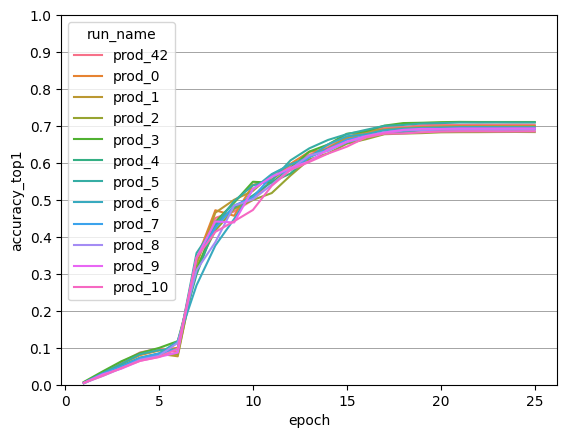

In [2]:
prod_tpu = df[
  df["run_name"].str.contains("prod")
  & df["hyperparameters"].str.contains("'lr': 0.01")
  & df["hyperparameters"].str.contains("xla")
]
sns.lineplot(
  data=prod_tpu,
  x="epoch",
  y="accuracy_top1",
  hue="run_name",
  markers=True,
  dashes=False,
)
plt.ylim(0, 1)
plt.yticks([i / 10 for i in range(11)])  # Ticks at 0.0, 0.1, ..., 1.0 (every 10%)
plt.grid(axis="y", which="both", color="gray", linestyle="-", linewidth=0.5)
plt.show()

## TPU vs GPU

With statistically significant tests and multiple runs on TPU and GPU, we can now make a direct comparison on convergence. Note that this is NOT a measure of TCO. For that, we would need to further tune the hyperparameters for optimal convergence, and then compare against the price. 

Let's plot the five TPU runs in blue and five GPU runs in red and see if we can eyeball a difference.

/tmp/ipykernel_2174470/147382305.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_tpu_labeled["device_type"] = "TPU"
/tmp/ipykernel_2174470/147382305.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_gpu_labeled["device_type"] = "GPU"


350


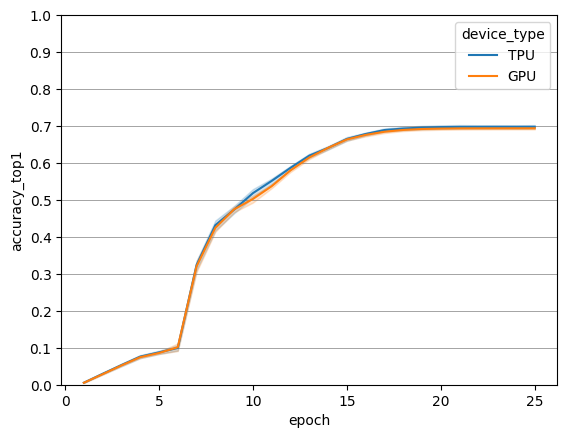

In [3]:
prod_tpu_labeled = df[
  df["run_name"].str.contains("prod")
  & df["hyperparameters"].str.contains("'lr': 0.01")
  & df["hyperparameters"].str.contains("xla")
]
prod_tpu_labeled["device_type"] = "TPU"

print(len(prod_tpu_labeled))

prod_gpu_labeled = df[
  df["run_name"].str.contains("prod")
  & df["hyperparameters"].str.contains("'lr': 0.01")
  & df["hyperparameters"].str.contains("cuda")
]
prod_gpu_labeled["device_type"] = "GPU"

# Combine the datasets
combined_data = pd.concat([prod_tpu_labeled, prod_gpu_labeled])

# Plot with device_type as hue instead of run_name
sns.lineplot(
  data=combined_data,
  x="epoch",
  y="accuracy_top1",
  hue="device_type",
  markers=True,
  dashes=False,
)
plt.ylim(0, 1)
plt.yticks([i / 10 for i in range(11)])  # Ticks at 0.0, 0.1, ..., 1.0 (every 10%)
plt.grid(axis="y", which="both", color="gray", linestyle="-", linewidth=0.5)
plt.show()

## t-test

The plot doesn't really indicate any difference. Let's run a t-test and see if there's a difference between the two. 

In [4]:
from scipy.stats import ttest_ind

tpu_top1 = prod_tpu_labeled[prod_tpu_labeled["epoch"] == 25]["accuracy_top1"].values
gpu_top1 = prod_gpu_labeled[prod_gpu_labeled["epoch"] == 25]["accuracy_top1"].values

print("TPU Top-1 Accuracy:", tpu_top1)
print("GPU Top-1 Accuracy:", gpu_top1)

tpu_names = prod_tpu_labeled[prod_tpu_labeled["epoch"] == 25]["run_name"].values
gpu_names = prod_gpu_labeled[prod_gpu_labeled["epoch"] == 25]["run_name"].values


print(len(tpu_top1))
print(len(gpu_top1))

t_stat, p_two_sided = ttest_ind(tpu_top1, gpu_top1, equal_var=False)  # Welch’s t-test

print(f"p-value (B != A): {p_two_sided}")

TPU Top-1 Accuracy: [0.7034 0.7034 0.6999 0.6994 0.6836 0.7108 0.7108 0.6905 0.7096 0.6967
 0.693  0.6904 0.6934 0.6855]
GPU Top-1 Accuracy: [0.6917 0.6912 0.6939 0.6915 0.6916 0.7017 0.701  0.6951 0.7092 0.6941
 0.6834 0.6911 0.6878 0.6888]
14
14
p-value (B != A): 0.17344679058804213


# GPU vs TPU t-test results

The visual observation of overlapping accuracy lines in the per-epoch chart is supported by the t-test. With a p-value of 0.173 (p > 0.05), the t-test indicated no statistically significant difference in the mean Top-1 accuracies between the TPU and GPU.